# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__
1) Which living outcome (education, health or happiness) do housing conditions affect the most?

2) Is there a correlation between precarious housing and health (both physical and mental) status?

3) In what ways do living conditions affect children scholarship (if they do) ? Which age group is most impacted ?


## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [2]:
# Make custom palettes for seaborn
colors = ['#BDDBD3','#B8B8FF'] #opal & lilac
#colors_light = ['#CAE2DC','#C2C2FF'] #opal & lilac
colors_light = ['#8FA3F8','#B6F3C9'] #light blue & light green
#colors_light = ['#CAF6D8','#B2BFFA'] #mint & lavender
#colors_dark=['#62A87C','#FDE74C']  #green & yellow
colors_dark = ['#9999FF','#B0D4CB'] #lilac & opal
customLight = sns.color_palette(colors_light)
customDark = sns.color_palette(colors_dark)
customPalette = sns.color_palette(colors)

In [3]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [4]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS']
family = ['UFAMSTR','UMH2','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS','NDEPRESA']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','CAGRAD','GHEADS','KAPPMED','SSHELP']
eco = ['CJOB','UHINS4'] #NB CJOB only for fc3

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0 or x >5) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs + eco]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh]

In [5]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the CJOB variable binary with Yes=1 and No=0
child['CJOB'].replace(2,0,inplace=True)
# Make the NLESSONS variable binary with Yes=1 and No=0
child['NLESSONS'].replace(2,0,inplace=True)
# Make the QSC5 variable (hh income vs 2x poverty line) binary with Below=0 and Above=1
child['QSC5'].replace({'1':0,'2':1,'':-1}, inplace=True)

# Normalize values for UENG(4-16), BHLTHN(1-5), UBPIA(6-18), UBPIB(6-18), UMH2(25-100), UACT(0-3) & NDEPRESA(1-4) (min-max)
child.loc[:,'UENGn'] = child['UENG'].apply(lambda x: (x-4)/(16-4) if x != -1 else x)
child.loc[:,'BHLTHNn'] = child['BHLTHN'].apply(lambda x: (x-1)/(5-1) if x != -1 else x)
child.loc[:,'UBPIAn'] = child['UBPIA'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UBPIBn'] = child['UBPIB'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UMH2n'] = child['UMH2'].apply(lambda x: (x-25)/(100-25) if x != -1 else x)
child.loc[:,'UACTn'] = child['UACT'].apply(lambda x: (x)/(3-0) if x != -1 else x)
child.loc[:,'NDEPRESA'] = child['NDEPRESA'].apply(lambda x: (5-x) if x != -1 else x)
child.loc[:,'NDEPRESAn'] = child['NDEPRESA'].apply(lambda x: (x-1)/(4-1) if x != -1 else x)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,HHID,UENG,...,MNBEDRMS,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,NDEPRESAn
0,5561612801,1,1,3,15,WI,2,A1,55616128,-1,...,4,1,0.75,-1.000000,0.00,-1.0,-1.000000,0.933333,-1.000000,0.000000
1,5470400001,2,0,14,15,WI,2,A1,54704000,8,...,2,2,1.50,0.333333,0.00,-1.0,0.416667,0.666667,0.333333,0.000000
2,5787427204,2,1,9,15,WI,2,A1,57874272,12,...,3,2,2.00,0.666667,0.50,1.0,-1.000000,1.000000,0.666667,0.000000
3,5410681601,1,0,4,15,WI,2,A1,54106816,-1,...,2,2,2.50,-1.000000,0.25,-1.0,-1.000000,0.666667,-1.000000,0.000000
4,5051721601,2,1,17,15,WI,2,A1,50517216,13,...,4,2,1.25,0.750000,0.25,-1.0,0.833333,0.253333,0.333333,0.666667


In [6]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal children, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal children, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal children, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal children, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [7]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 63)
fc2: (10925, 63)
fc3:(11087, 63)
fc23: (22012, 63)
True


## Propensity score

__Living conditions indicator :__

In [8]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [9]:
# Variables used for precarity indicator (economics and relationship with family)
# NB CHOICE OF WORDS : PRECARITY NOT VERY ACCURATE
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']

df_prec = df_NN(fc23,'PERSID',prec)

In [10]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them -> WE CAN CHOOSE WEIGHTS LATER TO TUNE THE INDEX
# NB performs column-wise automatically
norm_prec =(df_prec[prec]-df_prec[prec].min())/(df_prec[prec].max()-df_prec[prec].min())
norm_prec.loc[:,negative] *= -1

weights = [2.5,7,0.5,0.5,0.25,2]

# Compute living conditions indicator
norm_prec.loc[:,'living_ind'] = norm_prec.dot(weights)

# Choose a threshold to consider a household 'precarious' or not (we chose the value 1)
norm_prec.loc[:,'precarious'] = norm_prec['living_ind'].apply(lambda x : 1 if x < 0 else 0)

norm_prec['living_ind'].describe()

count    21515.000000
mean         1.531853
std          1.715291
min         -7.541667
25%          0.363095
50%          1.858631
75%          3.034722
max          4.416667
Name: living_ind, dtype: float64

In [11]:
# Merge this new column with whole df without NaNs
fc23_prec = pd.merge(fc23, norm_prec['precarious'], left_index=True, right_index=True, how='inner')

**PS with `bool0_5` as a treatment**

In [12]:
# logistic regression for CHLD0_5
# NB changed to fc23 rather than child, removed BHLTHN from PS calculation
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT','OVERCROWDING','BDISBL','UHINS4']
df_05 = df_NN(fc23,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + UHINS4'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()

Optimization terminated successfully.
         Current function value: 0.497091
         Iterations 6


In [13]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                21450
Model:                          Logit   Df Residuals:                    21434
Method:                           MLE   Df Model:                           15
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                  0.1650
Time:                        16:21:11   Log-Likelihood:                -10663.
converged:                       True   LL-Null:                       -12770.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.1513      0.232    -17.881      0.000      -4.606      -3.696
UREGION[T.2]    -0.0148      0.049     -0.302      0.762      -0.111       0.081
UREGION[T.3]     0.0214      0.050      0.432      0.666      -0.076       0.118
UREGION[T.4]    -0.0025      0.051     -0.049      0.961      -0.102       0.097
SEX              0.0012      0.034      0.035      0.972      -0.066       0.068
UFAMSTR         -0.0130      0.020     -0.658      0.510      -0.052       0.026
UMH2             0.0065      0.001      4.665      0.000       0.004       0.009
UMHIGDEG        -0.0246      0.009     -2.699      0.007      -0.042      -0.007
UAGG            -0.0290      0.010     -2.993      0.003      -0.048      -0.010
UHHCOUNT         0.7202      0.029     24.504      0.000       0.663       0.778
U_SOCPOV        -0.2046      0.018    -11.664      0.000      -0.239      -0.170
MNBEDRMS        -0.1368      0.042     -3.285      0.001      -0.218      -0.055
MOWNRENT         0.2278      0.039      5.900      0.000       0.152       0.303
OVERCROWDING     0.3172      0.073      4.319      0.000       0.173       0.461
BDISBL           0.2702      0.054      5.031      0.000       0.165       0.375
UHINS4          -0.0892      0.020     -4.408      0.000      -0.129      -0.050
================================================================================
"""

In [14]:
pred05 = res1.predict(df_05.copy())
df_05.loc[:,'PS'] = pred05

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### without matching

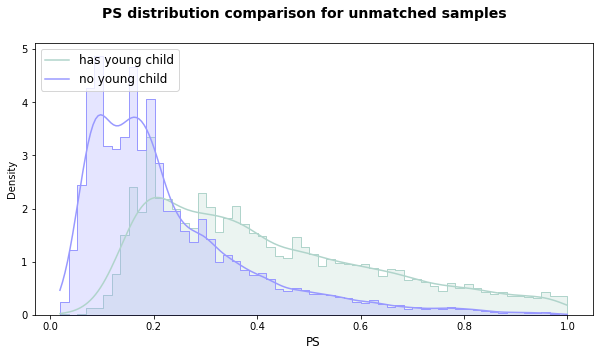

In [15]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_05, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False, palette= customDark)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

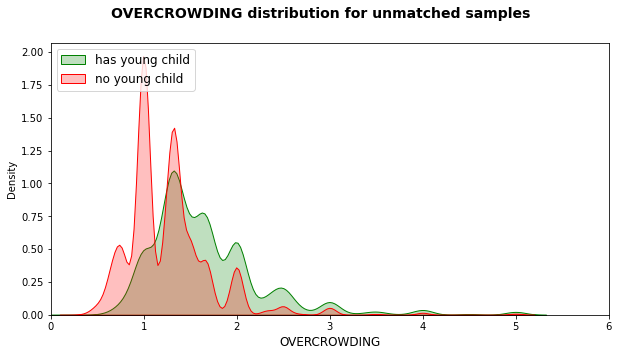

In [16]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_05, x=var, hue='bool0_5', palette=['r','g'], shade=True, common_norm=False)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

In [17]:
umh = df_05.groupby('bool0_5').mean()
print('Diff of mean = ' +str(umh['UMH2'][1] - umh['UMH2'][0]))

Diff of mean = 0.24524347171559668


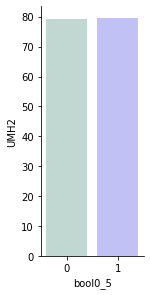

In [18]:
# not huge difference of about 0.33 -> could finish the conclusion by making bootstrap interval -> probably significant
sns.catplot(data=umh.reset_index(),x='bool0_5',y='UMH2',kind='bar', palette=customPalette, height=4, aspect=0.5)

#### with matching

In [19]:
# Finds closest PS to the input 'score' from the inputted array 'array'.
# Returns value of PS and its difference with 'score'.
def find_nearest(array, score):
    array = np.asarray(array)
    idx = (np.abs(array - score)).argmin()
    matchps = array[idx]
    return matchps, np.abs(matchps-score)

In [20]:
# Returns a dataframe containing two equally numbered populations (control, treatment) with ideally
# matched propensity scores
def optimatch(ctrl_df,trtm_df,alpha=0.01):
    idx=[]
    idtrtm=[]
    if (trtm_df.shape[0] > ctrl_df.shape[0]): # we iterate over the smaller dataframe and use the other one as a pool
        trtm_df, ctrl_df = ctrl_df, trtm_df
    iterative_df = trtm_df.reset_index(drop=True).copy().sample(frac=1) # shuffles the df so that we don't always preferentially optimize the first rows
    pool_df = ctrl_df.reset_index(drop=True).copy()
    for i in range(0,iterative_df.shape[0]):
        ps = iterative_df.iloc[i].PS
        matched, diff = find_nearest(pool_df.PS.drop(idx),ps)
        if (diff < alpha):
            idx.append(pool_df[pool_df.PS == matched].index[0]) 
            idtrtm.append(i)
    return pool_df.iloc[idx].append(iterative_df.iloc[idtrtm])

In [21]:
trtm0_5 = df_05[df_05.bool0_5 == 1].reset_index(drop=True)
ctrl0_5 = df_05[df_05.bool0_5 == 0].reset_index(drop=True)

# Perform matching between treated and non-treated samples
df_child05 = optimatch(trtm0_5,ctrl0_5,0.001)

print(f'Number of treated subjects (children) : {trtm0_5.shape[0]} \n\
Number of control subjects (no children) : {ctrl0_5.shape[0]} \n\
Number of matched pairs : {df_child05.shape[0]/2}')

Number of treated subjects (children) : 6060 
Number of control subjects (no children) : 15390 
Number of matched pairs : 5163.0


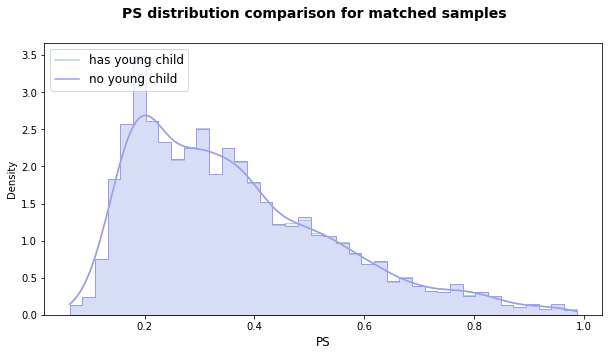

In [22]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_child05, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False, palette = customDark)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

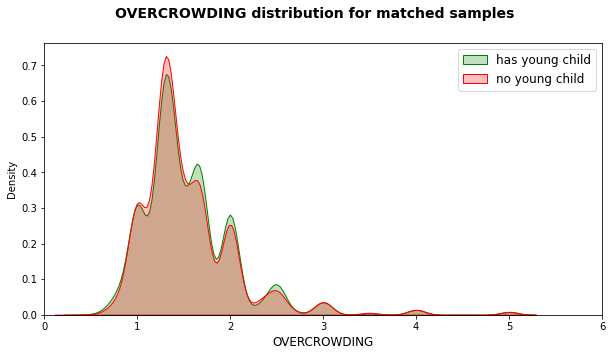

In [23]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_child05, x=var, hue='bool0_5', palette=['r','g'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper right', fontsize = 12)
plt.show()

# similar curves with matching !

In [24]:
means_child05 = df_child05.groupby('bool0_5').mean()
print('Diff of UMH2 mean = ' +str(means_child05['UMH2'][1] - means_child05['UMH2'][0]))
means_child05

Diff of UMH2 mean = -0.4751113693588991


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,NLESSONS,UFAMSTR,UMH2,UMHIGDEG,...,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,NDEPRESAn,PS
bool0_5,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.491962,12.140229,12.561302,0.221383,0.315321,0.321906,3.333140,79.700949,3.652528,...,1.324424,1.538128,0.707341,0.188456,-0.234247,0.056314,0.729346,0.484408,0.238234,0.365494
1,2.0,0.487120,9.481890,12.644199,0.192136,0.313577,0.316289,3.270773,79.225838,3.669572,...,1.340693,1.550481,0.713006,0.179450,0.370343,-0.555911,0.723011,0.451805,0.244625,0.365491


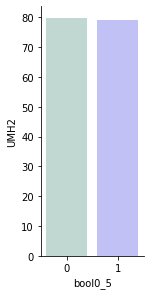

In [25]:
sns.catplot(data=means_child05.reset_index(),x='bool0_5',y='UMH2',kind='bar', palette=customPalette, height=4, aspect=0.5)

**PS with `NLESSONS` as treatment**

In [26]:
# logistic regression for NLESSONS
# NB removed BHLTHN
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS',
             'MOWNRENT','OVERCROWDING','BDISBL','CSPECED','UHINS4']
df_lessons = df_NN(fc23,'NLESSONS',predictors)

log_model_L = 'NLESSONS ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + CSPECED + UHINS4'

log_L = smf.logit(formula=log_model_L, data=df_lessons)
res_L = log_L.fit()
res_L.summary()

Optimization terminated successfully.
         Current function value: 0.599905
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               NLESSONS   No. Observations:                21263
Model:                          Logit   Df Residuals:                    21246
Method:                           MLE   Df Model:                           16
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.06086
Time:                        16:21:24   Log-Likelihood:                -12756.
converged:                       True   LL-Null:                       -13582.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.5165      0.216    -16.244      0.000      -3.941      -3.092
UREGION[T.2]    -0.2659      0.043     -6.226      0.000      -0.350      -0.182
UREGION[T.3]    -0.3959      0.044     -8.920      0.000      -0.483      -0.309
UREGION[T.4]    -0.2148      0.045     -4.804      0.000      -0.302      -0.127
SEX              0.7412      0.031     24.275      0.000       0.681       0.801
UFAMSTR          0.1303      0.018      7.248      0.000       0.095       0.165
UMH2             0.0054      0.001      4.266      0.000       0.003       0.008
UMHIGDEG         0.0998      0.008     12.031      0.000       0.084       0.116
UAGG             0.0133      0.009      1.491      0.136      -0.004       0.031
UHHCOUNT        -0.0744      0.026     -2.882      0.004      -0.125      -0.024
U_SOCPOV         0.1784      0.016     10.855      0.000       0.146       0.211
MNBEDRMS         0.1240      0.035      3.517      0.000       0.055       0.193
MOWNRENT         0.0612      0.036      1.679      0.093      -0.010       0.133
OVERCROWDING    -0.0508      0.071     -0.720      0.471      -0.189       0.087
BDISBL           0.2083      0.059      3.548      0.000       0.093       0.323
CSPECED          0.1808      0.058      3.131      0.002       0.068       0.294
UHINS4          -0.0705      0.019     -3.795      0.000      -0.107      -0.034
================================================================================
"""

In [27]:
pred_L = res_L.predict(df_lessons)
df_lessons.loc[:,'PS'] = pred_L

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


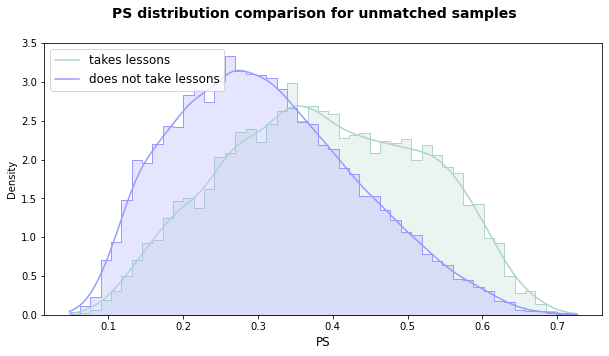

In [28]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_lessons, x="PS", hue='NLESSONS', kde=True, element='step', stat='density',
             common_norm=False, palette=customDark)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper left', fontsize = 12)
plt.show()

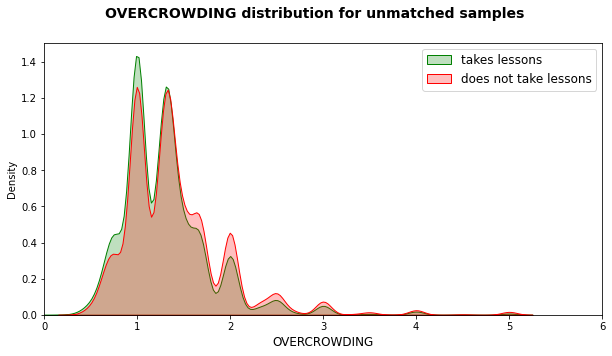

In [29]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_lessons, x=var, hue='NLESSONS', palette=['r','g'], shade=True, common_norm=False)
plt.xlim(0,6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper right', fontsize = 12)
plt.show()

In [30]:
means_L = df_lessons.groupby('NLESSONS').mean()
print('Diff of mean = ' +str(means_L['UENGPOS'][1] - means_L['UENGPOS'][0]))
means_L

Diff of mean = 0.1037447757156813


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,UFAMSTR,UMH2,UMHIGDEG,UAGG,...,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,NDEPRESAn,bool0_5,PS
NLESSONS,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.430840,11.633605,12.278270,0.251400,0.278625,3.120879,78.551365,3.566678,13.776108,...,1.402023,0.683032,0.194470,-0.126055,-0.069875,0.714018,0.339809,0.256174,0.293088,0.310731
1,2.0,0.609807,11.339480,13.145711,0.145571,0.382369,3.342274,80.787790,3.921347,13.988824,...,1.303671,0.756845,0.150286,-0.041469,-0.119621,0.743837,0.772795,0.219475,0.261246,0.387697


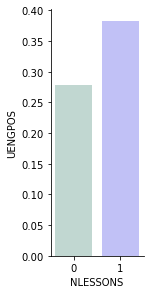

In [31]:
sns.catplot(data=means_L.reset_index(),x='NLESSONS',y='UENGPOS',kind='bar', palette=customPalette, height=4, aspect=0.5)

In [32]:
# Perform matching
trtm_L = df_lessons[df_lessons.NLESSONS == 1].sample(frac=1).reset_index(drop=True)
ctrl_L = df_lessons[df_lessons.NLESSONS == 0].sample(frac=1).reset_index(drop=True)

# Perform matching between treated and non-treated papers
df_L = optimatch(ctrl_L,trtm_L,0.001)

print(f'Number of treated subjects (lessons) : {trtm_L.shape[0]} \n\
Number of control subjects (no lessons) : {ctrl_L.shape[0]} \n\
Number of matched pairs : {df_L.shape[0]/2}')

Number of treated subjects (lessons) : 7158 
Number of control subjects (no lessons) : 14105 
Number of matched pairs : 6902.0


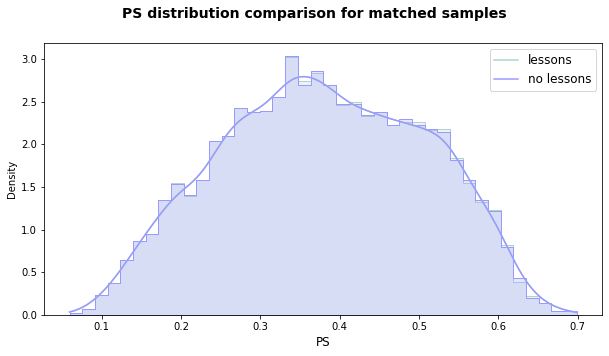

In [33]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_L, x="PS", hue='NLESSONS', kde=True, element='step', stat='density', 
             common_norm=False, palette=customDark)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['lessons','no lessons'], loc='upper right', fontsize = 12)
plt.show()

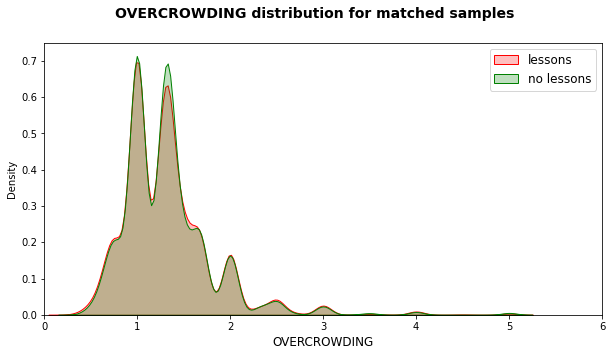

In [34]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_L, x=var, hue='NLESSONS', palette=['g','r'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['lessons','no lessons'], loc='upper right', fontsize = 12)
plt.show()

In [35]:
means_L = df_L.groupby('NLESSONS').mean()
print('Diff of mean = ' +str(means_L['UENGPOS'][1] - means_L['UENGPOS'][0]))
means_L

Diff of mean = 0.03969863807592


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,UFAMSTR,UMH2,UMHIGDEG,UAGG,...,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,NDEPRESAn,bool0_5,PS
NLESSONS,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.581571,11.831498,12.742104,0.192408,0.337873,3.342654,80.894089,3.890611,14.040133,...,1.313383,0.721916,0.169878,-0.153132,-0.011784,0.745255,0.370666,0.218922,0.259780,0.379773
1,2.0,0.595624,11.335990,13.118082,0.149377,0.377572,3.323240,80.630107,3.869748,13.971602,...,1.313917,0.754685,0.151949,-0.040471,-0.122320,0.741735,0.771709,0.221675,0.262967,0.379774


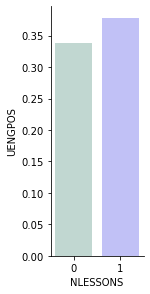

In [36]:
sns.catplot(data=means_L.reset_index(),x='NLESSONS',y='UENGPOS',kind='bar', palette=customPalette, height=4, aspect=0.5)

**PS with `precarious` as treatment**

In [37]:
# logistic regression for precarious
# NB removed UBPIA BHLTHN UENG
predictors= ['SEX','UAGE','UREGION','UMHIGDEG','UHHCOUNT','MNBEDRMS',
             'OVERCROWDING','BDISBL','CSPECED','UACT','CSPECED','UHINS4']
df_prec = df_NN(fc23_prec,'precarious',predictors)

log_model_prec = 'precarious ~ SEX + UAGE + UREGION + UMHIGDEG\
+ UHHCOUNT + MNBEDRMS + OVERCROWDING + BDISBL + CSPECED + UACT + CSPECED + UHINS4'

log_prec = smf.logit(formula=log_model_prec, data=df_prec)
res_prec = log_prec.fit()
res_prec.summary()

Optimization terminated successfully.
         Current function value: 0.331460
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                21317
Model:                          Logit   Df Residuals:                    21303
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                  0.3384
Time:                        16:21:39   Log-Likelihood:                -7065.7
converged:                       True   LL-Null:                       -10679.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.8899      0.313     -6.043      0.000      -2.503      -1.277
UREGION[T.2]    -0.2163      0.065     -3.324      0.001      -0.344      -0.089
UREGION[T.3]     0.2444      0.061      4.009      0.000       0.125       0.364
UREGION[T.4]    -0.0722      0.065     -1.104      0.269      -0.200       0.056
SEX              0.1206      0.043      2.778      0.005       0.036       0.206
UAGE             0.0083      0.006      1.331      0.183      -0.004       0.020
UMHIGDEG         0.0052      0.011      0.476      0.634      -0.016       0.027
UHHCOUNT         0.0790      0.057      1.385      0.166      -0.033       0.191
MNBEDRMS        -0.6895      0.091     -7.549      0.000      -0.869      -0.510
OVERCROWDING     1.7386      0.162     10.701      0.000       1.420       2.057
BDISBL          -0.4483      0.070     -6.414      0.000      -0.585      -0.311
CSPECED         -0.2467      0.070     -3.512      0.000      -0.384      -0.109
UACT            -0.3931      0.024    -16.489      0.000      -0.440      -0.346
UHINS4           0.7311      0.021     34.831      0.000       0.690       0.772
================================================================================
"""

In [38]:
pred_prec = res_prec.predict(df_prec)
df_prec.loc[:,'PS'] = pred_prec

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


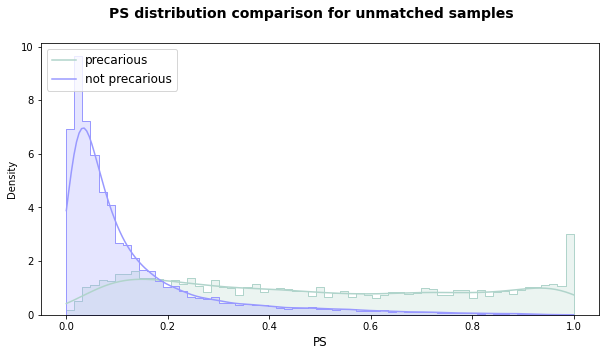

In [39]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_prec, x="PS", hue='precarious', kde=True, element='step', stat='density',
             common_norm=False, palette=customDark)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper left', fontsize = 12)
plt.show()

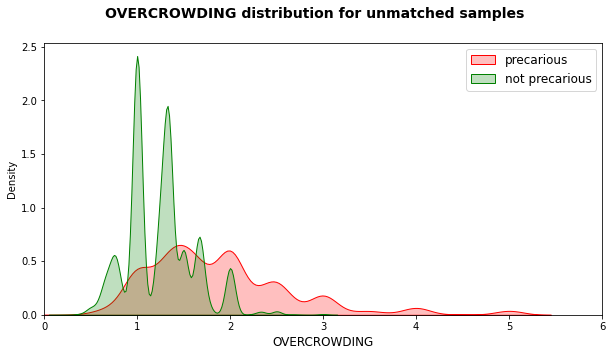

In [40]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_prec, x=var, hue='precarious', palette=['g','r'], shade=True, common_norm=False)
plt.xlim(0,6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

In [41]:
means_prec = df_prec.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGPOS'][0] - means_prec['UENGPOS'][1]))
means_prec

Diff of mean = 0.10530150966322899


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,NLESSONS,UFAMSTR,UMH2,UMHIGDEG,...,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,NDEPRESAn,bool0_5,PS
precarious,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.490525,11.630566,12.740158,0.195189,0.334702,0.363156,3.407334,80.385978,3.659490,...,1.239052,0.722529,0.155925,-0.114159,-0.059020,0.737483,0.522695,0.222841,0.239190,0.127817
1,2.0,0.494382,11.160112,11.900749,0.297519,0.229401,0.224251,2.349953,74.338483,3.797519,...,1.887354,0.650203,0.274754,-0.033942,-0.196259,0.656776,0.336532,0.324204,0.452013,0.490020


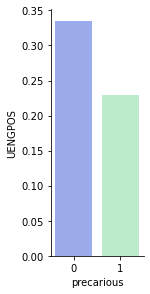

In [42]:
sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGPOS',kind='bar', palette=customLight, height=4, aspect=0.5)

In [43]:
# Perform matching
trtm_prec = df_prec[df_prec.precarious == 1].reset_index(drop=True)
ctrl_prec = df_prec[df_prec.precarious == 0].reset_index(drop=True)

# Perform matching between treated and non-treated papers
df_prec = optimatch(ctrl_prec,trtm_prec,0.001)

print(f'Number of treated subjects (precarious) : {trtm_prec.shape[0]} \n\
Number of control subjects (not precarious) : {ctrl_prec.shape[0]} \n\
Number of matched pairs : {df_prec.shape[0]/2}')

Number of treated subjects (precarious) : 4272 
Number of control subjects (not precarious) : 17045 
Number of matched pairs : 2998.0


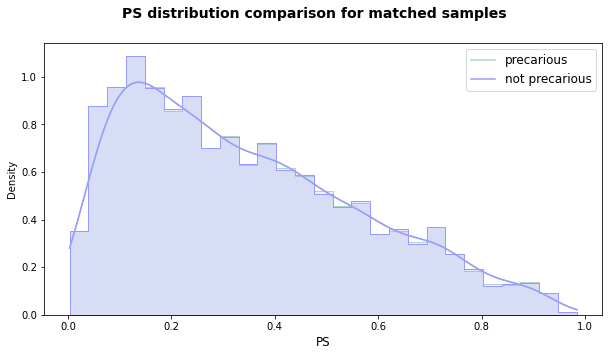

In [44]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_prec, x="PS", hue='precarious', kde=True, element='step', stat='density',palette=customDark)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

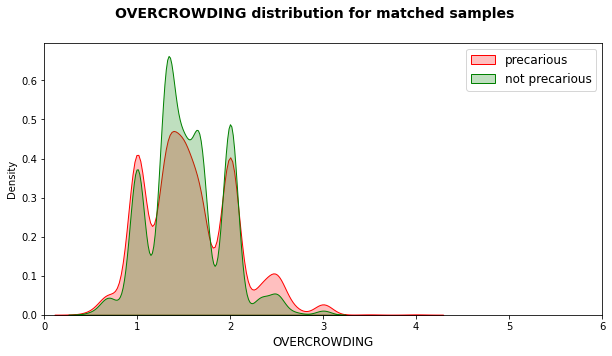

In [45]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_prec, x=var, hue='precarious', palette=['g','r'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

In [46]:
means_prec = df_prec.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGPOS'][0] - means_prec['UENGPOS'][1]))

Diff of mean = 0.024016010673782506


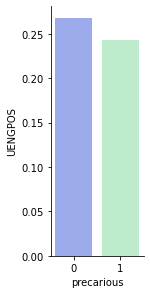

In [47]:
sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGPOS',kind='bar',palette=customLight, height=4, aspect=0.5)

### General description of precariousness

<AxesSubplot:xlabel='UFAMSTR', ylabel='Probability'>

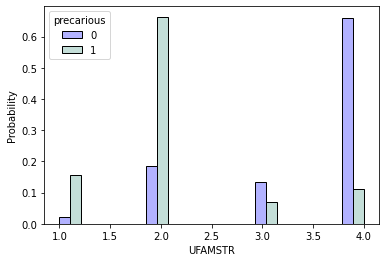

In [48]:
sns.histplot(x='UFAMSTR', hue='precarious', stat='probability', data=df_NN(df_prec,'precarious', ['UFAMSTR']),
             common_norm=False, multiple='dodge', palette=customDark)
# Quelles structures familiales amènent la précarité?

## Linear regression models

In [49]:
# returns a regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## Education

In [50]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1426.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           5.68e-59
Time:                        16:21:48   Log-Likelihood:                -48807.
No. Observations:               21054   AIC:                         9.764e+04
Df Residuals:                   21041   BIC:                         9.774e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.0938      0.285     17.848   

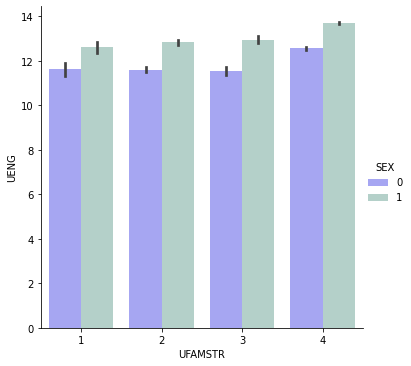

In [51]:
sns.catplot(y='UENG', x='UFAMSTR', hue='SEX', kind='bar', palette=customDark, data=df_NN(fc23,outcome,predictors))

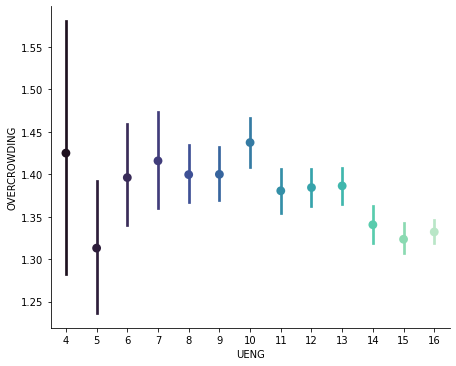

In [52]:
sns.catplot(x='UENG', y='OVERCROWDING',kind='point', palette='mako', data=df_NN(fc23,outcome,predictors),height=5,aspect=1.25)

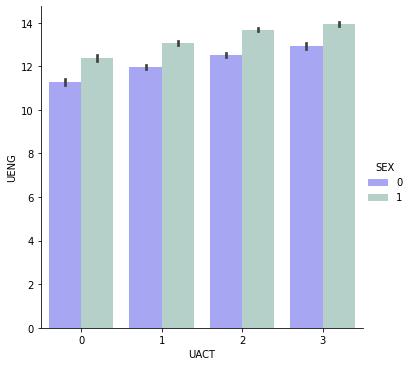

In [53]:
sns.catplot(y='UENG', x='UACT', hue='SEX', palette=customDark, kind='bar', data=df_NN(fc23,outcome,predictors))

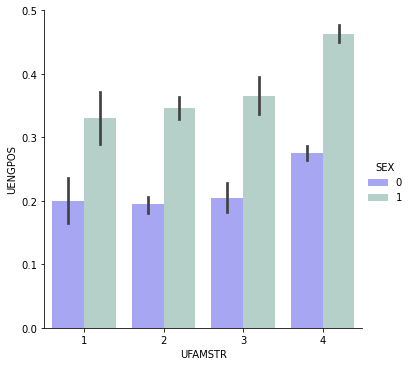

In [54]:
var='UENGPOS'
sns.catplot(x='UFAMSTR', y=var, hue='SEX', kind='bar', palette=customDark, data=df_NN(fc23,var,['UFAMSTR']))
# filles + scolaires, plus la structure familiale est confortable, meilleur est l'engagment scolaire positif

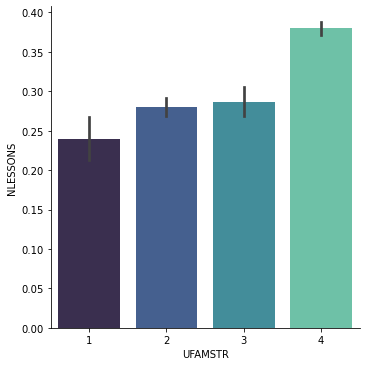

In [55]:
var='NLESSONS'
sns.catplot(x='UFAMSTR', y=var, kind='bar', palette='mako', data=df_NN(child,var,['UFAMSTR']))
# Plus la structure familiale est confortable, + les lessons sont prises

<AxesSubplot:xlabel='UFAMSTR', ylabel='Probability'>

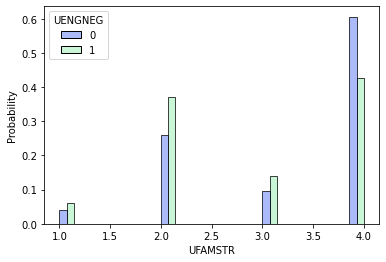

In [56]:
sns.histplot(x='UFAMSTR', hue='UENGNEG', stat='probability', data=df_NN(fc23,'UENGNEG', ['UFAMSTR']),
             common_norm=False, multiple='dodge', palette=customLight)
# dans quelles familles sont distribués les enfants peu engagés ?

## Health

In [57]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     327.1
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.48e-42
Time:                        16:21:52   Log-Likelihood:                -26866.
No. Observations:               21437   AIC:                         5.376e+04
Df Residuals:                   21425   BIC:                         5.385e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1978      0.090     35.457   

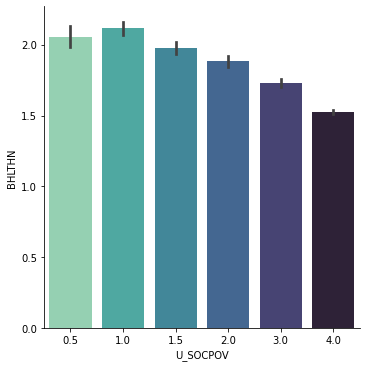

In [58]:
g = sns.catplot(x='U_SOCPOV', y='BHLTHN',kind='bar',palette='mako_r', data=df_NN(fc23,outcome,predictors), orient='v')

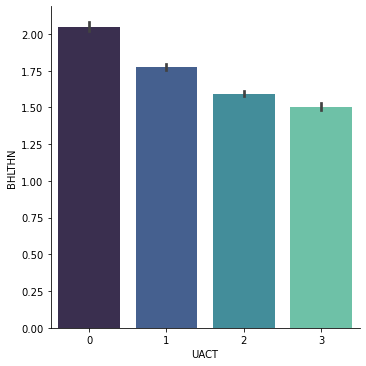

In [59]:
sns.catplot(x='UACT', y='BHLTHN',kind='bar', palette='mako', data=df_NN(fc23,outcome,predictors))

## Mental health

In [92]:
outcome = 'NDEPRESAn'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              NDEPRESAn   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     1491.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           6.90e-59
Time:                        16:24:02   Log-Likelihood:                 3986.5
No. Observations:               10604   AIC:                            -7949.
Df Residuals:                   10592   BIC:                            -7862.
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4984      0.023     64.210   

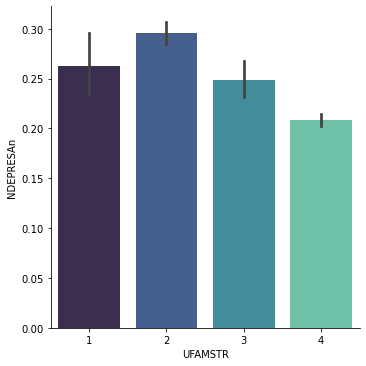

In [93]:
sns.catplot(y='NDEPRESAn', x='UFAMSTR', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

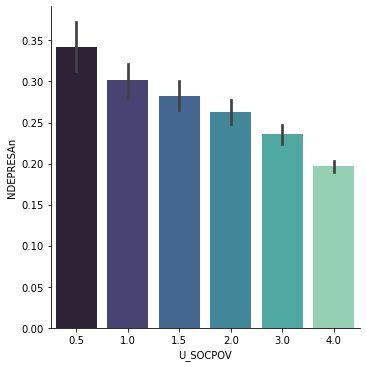

In [94]:
sns.catplot(y='NDEPRESAn', x='U_SOCPOV', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

**fc2**

In [63]:
outcome = 'UBPIA'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     619.5
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.09e-49
Time:                        16:21:54   Log-Likelihood:                -21244.
No. Observations:               10566   AIC:                         4.251e+04
Df Residuals:                   10554   BIC:                         4.260e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.7579      0.234     33.088   

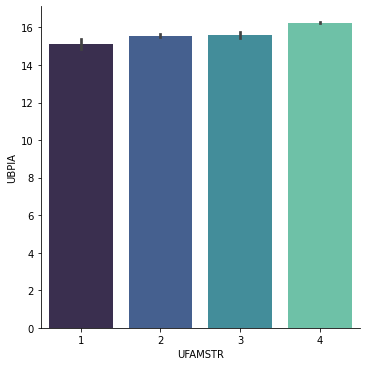

In [64]:
sns.catplot(y='UBPIA', x='UFAMSTR', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

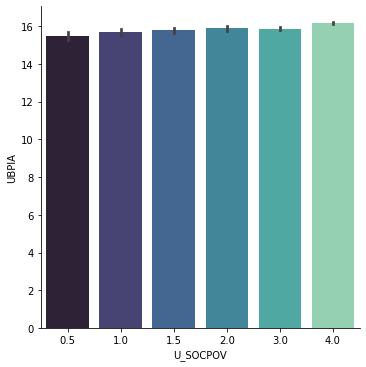

In [65]:
sns.catplot(y='UBPIA', x='U_SOCPOV', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

**fc3**

In [66]:
outcome = 'UBPIB'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     664.5
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.66e-50
Time:                        16:21:55   Log-Likelihood:                -21979.
No. Observations:               10777   AIC:                         4.398e+04
Df Residuals:                   10765   BIC:                         4.407e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7982      0.325     17.817   

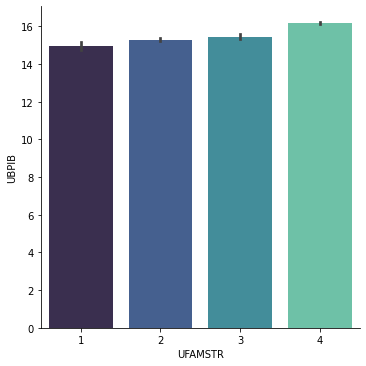

In [67]:
sns.catplot(y='UBPIB', x='UFAMSTR', kind='bar', palette='mako', data=df_NN(fc3,outcome,predictors))

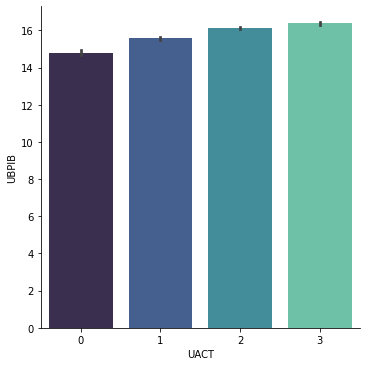

In [68]:
sns.catplot(y='UBPIB', x='UACT', kind='bar', palette='mako', data=df_NN(fc3,outcome,predictors))

**Parents**

In [69]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     48.37
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           4.37e-20
Time:                        16:21:56   Log-Likelihood:            -1.3326e+05
No. Observations:               33501   AIC:                         2.665e+05
Df Residuals:                   33493   BIC:                         2.666e+05
Df Model:                           7                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       71.8627      1.023     70.229   

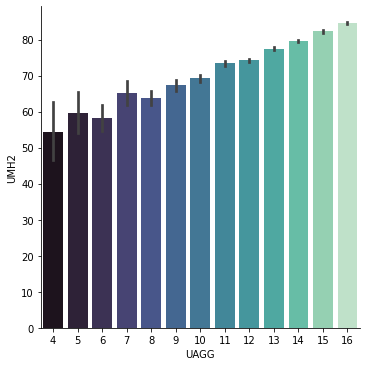

In [70]:
var='UMH2'
sns.catplot(x='UAGG', y=var, kind='bar', palette='mako', data=df_NN(child,var,['UAGG']))
# mental health des parents directement corrélée avec le fait que le gamin soit insupportable (UAGG bas = insupportable)

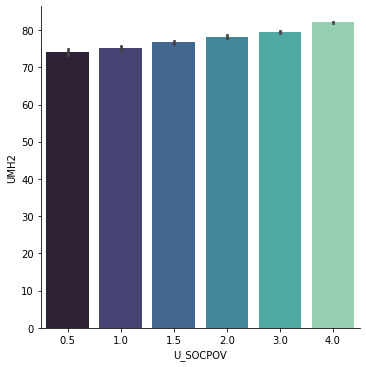

In [71]:
var='UMH2'
sns.catplot(x='U_SOCPOV', y=var, kind='bar', palette='mako', data=df_NN(child,var,['U_SOCPOV']))
# mental health des parents directement corrélée avec l'aisance financière'

## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Average treatment effect on schooling, health & happiness

Using the matched pairs we can compute the average treatment (young child and precarity) effect on our variables of interest.

__ATE of having a young child (or children) in the household__

In [72]:
# Computes CI
def CI(alpha, data):    
    ci = sms.DescrStatsW(data).tconfint_mean(alpha)
    return ci

In [73]:
# computes and returns the significance (***=1%, **=5%, *=10%)
def stars(ci):
    if np.sign(ci[2][0]) == np.sign(ci[2][1]):
        return '***'
    elif np.sign(ci[1][0]) == np.sign(ci[1][1]):
        return '**'
    elif np.sign(ci[0][0]) == np.sign(ci[0][1]):
        return '*'
    else:
        return 'Not significant'

In [74]:
# Computes average treatment effect of 'treatment_var' on the variable of interest 'voi'
def ATE (data, treatment_var, voi):
    # keep only valid data for voi (no NaNs)
    df = df_NN(data,treatment_var,[voi])
    # perform matching
    treated = df[df[treatment_var] == 1].reset_index(drop=True)
    control = df[df[treatment_var] == 0].reset_index(drop=True)
    df_match = optimatch(treated,control,0.001)
    print(f'Number of matched subjects: {df_match.shape[0]} / {df.shape[0]}')

    pairs_difference = df_match.loc[df_match[treatment_var]==1,voi].values - df_match.loc[df_match[treatment_var]==0,voi].values
    
    ate = sum(pairs_difference)/pairs_difference.size
    ci = [ CI(0.1, pairs_difference), CI(0.05, pairs_difference), CI(0.01, pairs_difference)]
    star = stars(ci)
    
    return ate, ci, star

In [75]:
# Computes ATE of 'treatment_var' on several variables of interest listed in 'list_voi'
# Returns a dataframe with the variables and their ATE
def multiple_ATE (data, treatment_var, list_voi):
    ates = []
    stars = []
    ci90 = []
    ci95 = []
    ci99 = []
    
    for var in list_voi:
        print(var)
        ate, ci, star = ATE(data, treatment_var, var)
        ates.append(ate)
        stars.append(star)
        ci90.append(ci[0])
        ci95.append(ci[1])
        ci99.append(ci[2])
        
    df_ate = pd.DataFrame({'variable': list_voi, 'ATE': ates, 'ci90': ci90, 'ci95': ci95, 'ci99': ci99,
                           'Significance': stars})
    
    # nice display of confidence intervals
    for i in range(3):
        col = ['ci90','ci95','ci99']
        col_fmd = ['90% CI','95% CI','99% CI']
        df_ate.loc[:,col_fmd[i]] = df_ate[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')
    
    # ATE significance at the 95% level (positive or negative)
    df_ate.loc[:,'sig95'] = df_ate['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + df_ate['ATE'].apply(lambda x : 1 if x > 0 else 0)
    df_ate['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
    
    return df_ate

In [76]:
# Returns dataframe with variables of interest in this study with their confidence intervals and significance
def ATE_sch_hlth_happ (data, treatment_var, interest_var, fc2=False,fc3=False):
    ate = multiple_ATE(data, treatment_var, interest_var)
    if (fc2==True):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        return ate.append(ate_ubpia, ignore_index=True)
    if (fc3==True):
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpib, ignore_index=True)
    if ((fc2==False)and(fc3==False)):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpia.append(ate_ubpib,ignore_index=True), ignore_index=True)

In [77]:
# Plots ATEs of 'df' with 'treatment' (must be in ['child05','lessons','precarious'])
def plot_ATE (df, treatment):
    treatment_list = {'lessons' : 'taking lessons outside of school',
                      'precarious' : 'precarious living conditions'}
    tr = treatment_list[treatment]
    
    plt.figure(figsize=(10,5))
    groups = df.sort_values('ATE').groupby('sig95', sort=False)
    for sig, group in groups:
        error = group['ci95'].apply(pd.Series).to_numpy()
        length_error = abs(error[:,0] - group.ATE.values)
        plt.errorbar(group.ATE, group.variable, marker='o', ls='', xerr=length_error, capsize=3, elinewidth=1,
                     label=sig)
    plt.axvline(0,color='k',linestyle='--')
    plt.xlabel('ATE (with 95% CI)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Normalized average treatment effect (nATE) of ' + tr + ' on several variables',
              fontweight='bold', fontsize=14)
    plt.legend()
    plt.show()

__ATE of taking lessons outside of school__

In [78]:
ate_lessons = ATE_sch_hlth_happ(df_L, 'NLESSONS', ['UENGn','UENGNEG','UENGPOS','BHLTHNn','UMH2n','NDEPRESAn'])
ate_lessons[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 13600 / 13665
UENGNEG
Number of matched subjects: 13610 / 13665
UENGPOS
Number of matched subjects: 13610 / 13665
BHLTHNn
Number of matched subjects: 13790 / 13804
UMH2n
Number of matched subjects: 13792 / 13804
NDEPRESAn
Number of matched subjects: 13776 / 13796
UBPIAn
Number of matched subjects: 5924 / 6746
UBPIBn
Number of matched subjects: 6120 / 7006


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,0.033002,[0.027136 ; 0.038869],[0.026012 ; 0.039993],[0.023814 ; 0.042190],***
1,UENGNEG,-0.049522,[-0.060150 ; -0.038895],[-0.062186 ; -0.036859],[-0.066167 ; -0.032878],***
2,UENGPOS,0.047759,[0.034295 ; 0.061223],[0.031715 ; 0.063803],[0.026671 ; 0.068847],***
3,BHLTHNn,-0.020160,[-0.025978 ; -0.014341],[-0.027093 ; -0.013226],[-0.029273 ; -0.011046],***
4,UMH2n,-0.002744,[-0.007104 ; 0.001616],[-0.007939 ; 0.002452],[-0.009572 ; 0.004085],Not significant
5,NDEPRESAn,0.002710,[-0.004105 ; 0.009525],[-0.005411 ; 0.010831],[-0.007964 ; 0.013384],Not significant
6,UBPIAn,-0.013082,[-0.019647 ; -0.006518],[-0.020905 ; -0.005260],[-0.023365 ; -0.002799],***
7,UBPIBn,0.019063,[0.012156 ; 0.025970],[0.010832 ; 0.027294],[0.008244 ; 0.029883],***


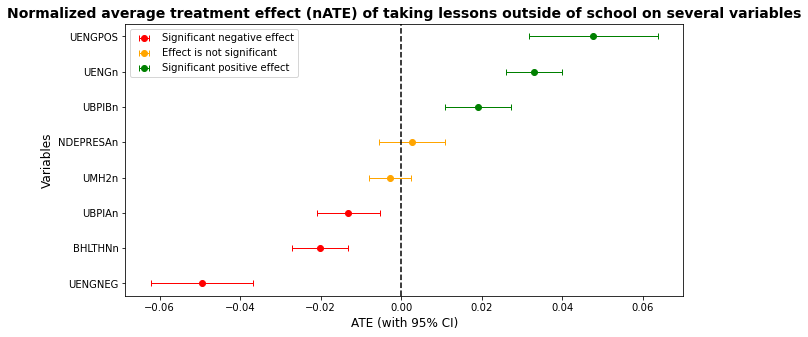

In [79]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'orange', 'green']) 

plot_ATE(ate_lessons,'lessons')

__ATE of precarious household__

In [80]:
ate_precarious = ATE_sch_hlth_happ(df_prec, 'precarious',['UENGn','UENGNEG','UENGPOS','BHLTHNn','UMH2n','UACTn','NDEPRESAn'])
ate_precarious[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 5778 / 5922
UENGNEG
Number of matched subjects: 5776 / 5922
UENGPOS
Number of matched subjects: 5770 / 5922
BHLTHNn
Number of matched subjects: 5876 / 5996
UMH2n
Number of matched subjects: 5864 / 5985
UACTn
Number of matched subjects: 5874 / 5996
NDEPRESAn
Number of matched subjects: 5874 / 5986
UBPIAn
Number of matched subjects: 2634 / 3152
UBPIBn
Number of matched subjects: 2248 / 2801


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.021605,[-0.031772 ; -0.011438],[-0.033721 ; -0.009489],[-0.037532 ; -0.005677],***
1,UENGNEG,0.043283,[0.023563 ; 0.063002],[0.019783 ; 0.066782],[0.012391 ; 0.074174],***
2,UENGPOS,-0.028076,[-0.047206 ; -0.008946],[-0.050874 ; -0.005279],[-0.058044 ; 0.001892],**
3,BHLTHNn,0.058713,[0.048080 ; 0.069347],[0.046042 ; 0.071385],[0.042056 ; 0.075370],***
4,UMH2n,-0.054470,[-0.063043 ; -0.045897],[-0.064686 ; -0.044254],[-0.067900 ; -0.041041],***
5,UACTn,0.002043,[-0.009913 ; 0.013999],[-0.012205 ; 0.016291],[-0.016687 ; 0.020772],Not significant
6,NDEPRESAn,0.059812,[0.047007 ; 0.072617],[0.044552 ; 0.075071],[0.039752 ; 0.079871],***
7,UBPIAn,-0.028094,[-0.039987 ; -0.016202],[-0.042268 ; -0.013920],[-0.046732 ; -0.009457],***
8,UBPIBn,-0.037367,[-0.051141 ; -0.023592],[-0.053784 ; -0.020949],[-0.058956 ; -0.015777],***


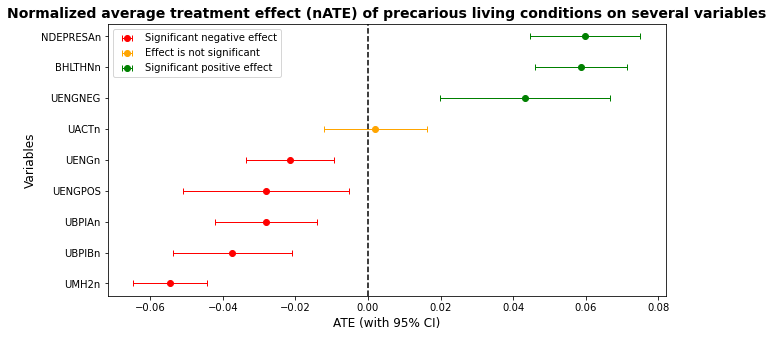

In [81]:
plot_ATE(ate_precarious,'precarious')

### 3) fc2 or fc3

In [82]:
ate_precarious_fc2 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] < 12],'precarious',['UENGn','UENGNEG','UENGPOS','BHLTHNn','UMH2n','UACTn','NDEPRESAn'],fc2=True)
ate_precarious_fc2[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 2660 / 3155
UENGNEG
Number of matched subjects: 2650 / 3155
UENGPOS
Number of matched subjects: 2664 / 3155
BHLTHNn
Number of matched subjects: 2672 / 3174
UMH2n
Number of matched subjects: 2668 / 3171
UACTn
Number of matched subjects: 2680 / 3174
NDEPRESAn
Number of matched subjects: 2686 / 3172
UBPIAn
Number of matched subjects: 2652 / 3152


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.026003,[-0.039843 ; -0.012162],[-0.042498 ; -0.009507],[-0.047692 ; -0.004313],***
1,UENGNEG,0.043774,[0.017544 ; 0.070003],[0.012513 ; 0.075034],[0.002668 ; 0.084879],***
2,UENGPOS,-0.022523,[-0.051390 ; 0.006345],[-0.056928 ; 0.011883],[-0.067763 ; 0.022718],Not significant
3,BHLTHNn,0.051085,[0.035480 ; 0.066691],[0.032486 ; 0.069685],[0.026629 ; 0.075542],***
4,UMH2n,-0.044258,[-0.056915 ; -0.031601],[-0.059343 ; -0.029173],[-0.064094 ; -0.024422],***
5,UACTn,-0.025373,[-0.042829 ; -0.007917],[-0.046178 ; -0.004568],[-0.052730 ; 0.001983],**
6,NDEPRESAn,0.048151,[0.029692 ; 0.066610],[0.026151 ; 0.070151],[0.019223 ; 0.077078],***
7,UBPIAn,-0.032177,[-0.043954 ; -0.020400],[-0.046213 ; -0.018141],[-0.050634 ; -0.013720],***


In [83]:
ate_precarious_fc3 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] >= 12],'precarious', ['UENGn','UENGNEG','UENGPOS','BHLTHNn','UMH2n','UACTn','NDEPRESAn'], fc3=True)
ate_precarious_fc3[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 2220 / 2767
UENGNEG
Number of matched subjects: 2206 / 2767
UENGPOS
Number of matched subjects: 2226 / 2767
BHLTHNn
Number of matched subjects: 2262 / 2822
UMH2n
Number of matched subjects: 2268 / 2814
UACTn
Number of matched subjects: 2270 / 2822
NDEPRESAn
Number of matched subjects: 2264 / 2814
UBPIBn
Number of matched subjects: 2246 / 2801


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.005556,[-0.022391 ; 0.011280],[-0.025621 ; 0.014510],[-0.031943 ; 0.020832],Not significant
1,UENGNEG,0.022665,[-0.011333 ; 0.056664],[-0.017857 ; 0.063188],[-0.030624 ; 0.075954],Not significant
2,UENGPOS,-0.023360,[-0.053007 ; 0.006286],[-0.058695 ; 0.011975],[-0.069828 ; 0.023107],Not significant
3,BHLTHNn,0.057471,[0.040403 ; 0.074540],[0.037128 ; 0.077814],[0.030719 ; 0.084223],***
4,UMH2n,-0.065315,[-0.079308 ; -0.051321],[-0.081993 ; -0.048637],[-0.087247 ; -0.043382],***
5,UACTn,0.029075,[0.009677 ; 0.048473],[0.005955 ; 0.052194],[-0.001328 ; 0.059478],**
6,NDEPRESAn,0.079800,[0.059019 ; 0.100580],[0.055032 ; 0.104568],[0.047229 ; 0.112370],***
7,UBPIBn,-0.041778,[-0.055580 ; -0.027976],[-0.058229 ; -0.025327],[-0.063411 ; -0.020145],***


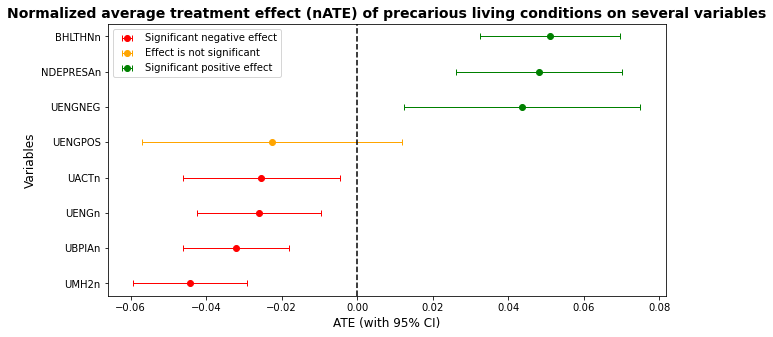

In [84]:
plot_ATE(ate_precarious_fc2,'precarious')

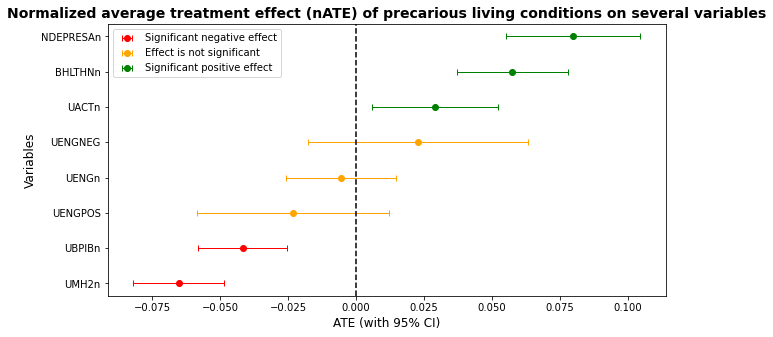

In [85]:
plot_ATE(ate_precarious_fc3,'precarious')

In [86]:
age_diff = pd.DataFrame(ate_precarious_fc3.variable)
ci90s = []
ci95s = []
ci99s = []
for i in range (0,ate_precarious_fc3.variable.size):
    ate = ate_precarious_fc3['ATE'][i] - ate_precarious_fc2['ATE'][i]
    age_diff.loc[i,'ATE'] = ate
    
    #ci qui est la diff des coordonnées des ci de fc2 et fc3 : 
    ci=[(ate_precarious_fc3['ci90'][i][0] - ate_precarious_fc2['ci90'][i][0],ate_precarious_fc3['ci90'][i][1] - ate_precarious_fc2['ci90'][i][1]),(ate_precarious_fc3['ci95'][i][0] - ate_precarious_fc2['ci95'][i][0],ate_precarious_fc3['ci95'][i][1] - ate_precarious_fc2['ci95'][i][1]),(ate_precarious_fc3['ci99'][i][0] - ate_precarious_fc2['ci99'][i][0],ate_precarious_fc3['ci99'][i][1] - ate_precarious_fc2['ci99'][i][1])]
   
    ci90s.append(ci[0])
    ci95s.append(ci[1])
    ci99s.append(ci[2])
    age_diff.loc[i,'Significance'] = stars(ci)
    age_diff.loc[:,'sig95'] = age_diff['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + age_diff['ATE'].apply(lambda x : 1 if x > 0 else 0)
    age_diff['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
age_diff['ci90'] = ci90s
age_diff['ci95'] = ci95s
age_diff['ci99'] = ci99s

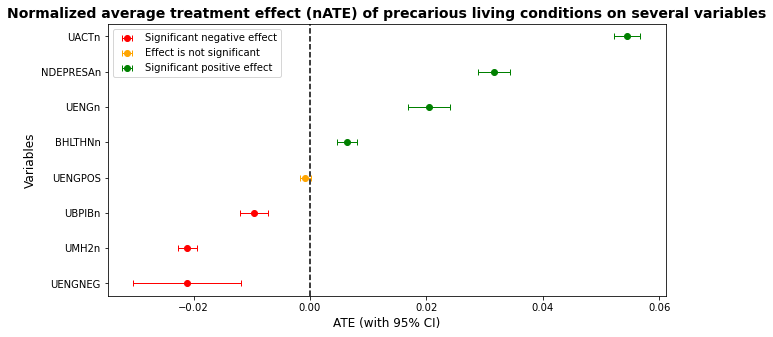

In [87]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'orange', 'green']) 

plot_ATE(age_diff,'precarious')

#### fc3 - fc2 pour les valeurs, aucune des deux méthodes de CI me convient mais la première donne un meilleur truc (visuellement en tt cas) \\
     Plus le point est à adroite, + la variable en question est impactée par la précarité pour les 12-17. Plus c'est à gauche, plus la variable en question est impactée par la précarité pour les 6-11.

### Effect of family structure on school

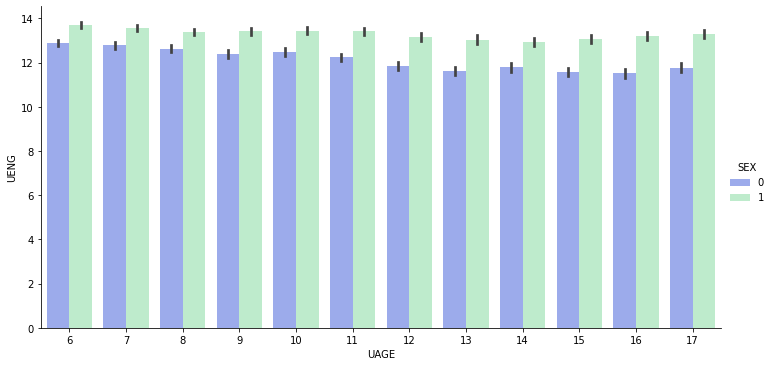

In [88]:
var='UENG'
sns.catplot(x='UAGE', y=var, kind='bar', hue = 'SEX', palette=customLight, data=df_NN(fc23,var,['UAGE','SEX']), height=5, aspect=2)
# légère baisse de l'eng avec l'age chez les garçons mais pas flagrant (pas certaine de la significance),
# pas significant chez les filles
# UENG ne concerne que fc23

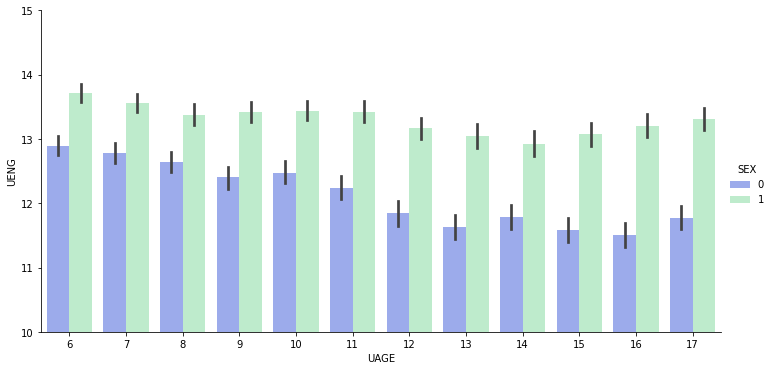

In [89]:
var='UENG'
ax = sns.catplot(x='UAGE', y=var, kind='bar', hue = 'SEX', palette=customLight,
                 data=df_NN(fc23,var,['UAGE','SEX']), height=5, aspect=2)
ax.set(ylim=(10, 15))
# ZOOM
# légère baisse de l'eng avec l'age chez les garçons vers 12 ans,
# bcp moins significant chez les filles

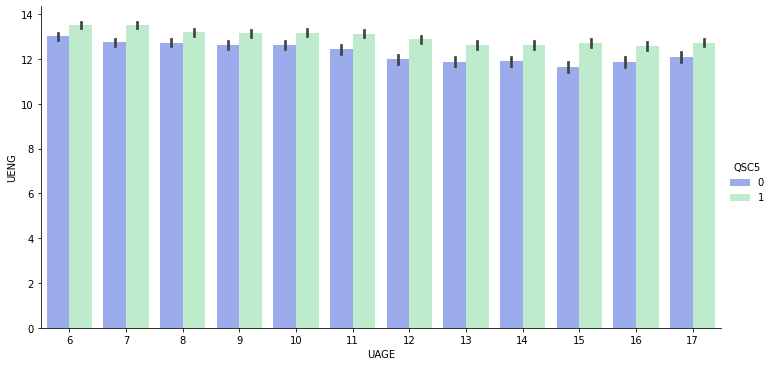

In [90]:
var='UENG'
sns.catplot(x='UAGE', y=var, kind='bar', hue = 'QSC5', palette=customLight, data=df_NN(fc23,var,['UAGE','QSC5']), height=5, aspect=2)
# engagement à l'école vs age + income (above or below 2x poverty line)
# pas significant chez les filles
# UENG ne concerne que fc23

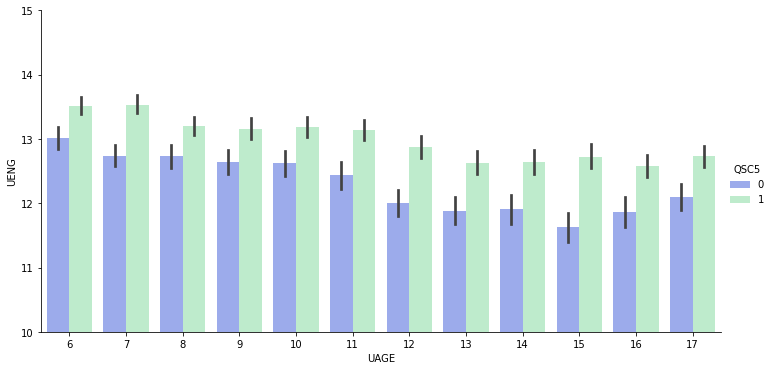

In [91]:
var='UENG'
ax = sns.catplot(x='UAGE', y=var, kind='bar', hue = 'QSC5', palette=customLight,
                 data=df_NN(fc23,var,['UAGE','QSC5']), height=5, aspect=2)
ax.set(ylim=(10,15))
# ZOOM
# baisse de l'engagement vers 12 ans, plus significant chez les plus pauvres